# Train with MIRACLE

In [3]:
from modules.MIRACLE import MIRACLE, create_data
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import pandas as pd
import torch
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
tasks= ['dig_ctrl', 'dig_stim', 'lll_ctrl', 'lll_stim']
labels = {
    'subset_0':'./data/sct/atac+rna+adt/dogma/dig_ctrl/label_seurat/l1.csv',
    'subset_1':'./data/sct/atac+rna+adt/dogma/dig_stim/label_seurat/l1.csv',
    'subset_2':'./data/sct/atac+rna+adt/dogma/lll_ctrl/label_seurat/l1.csv',
    'subset_3':'./data/sct/atac+rna+adt/dogma/lll_stim/label_seurat/l1.csv',
}

## Train the first batch

Initialize

In [4]:
task = 1
data1 = create_data('./data/processed/%s'%tasks[task-1])
data = [data1]
status = ['current']
miracle= MIRACLE(data, status)

1 subset(s) in this path {'atac': 52867, 'adt': 208}
  subset_0 : 10190 cells ; ['atac', 'adt']


Init model training mod

In [5]:
miracle.init_model('denovo')

Parameter number: 15.982 M


Train

In [6]:
miracle.train(n_epoch=2000, save_path='./result/task_%d/train/'%task)

Training ...
0 tasks used as replay data, 1 tasks used as current training data


  0%|          | 0/2000 [00:00<?, ?it/s]

Loss: 10980.7365: 100%|██████████| 2000/2000 [10:07:02<00:00, 18.21s/it] 


Explore training status

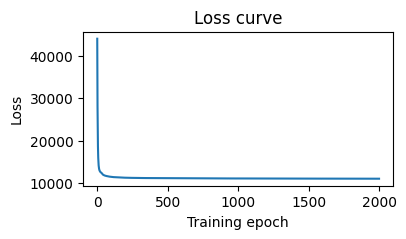

In [7]:
miracle.viz_loss()

Get embeddings

In [8]:
miracle.predict(save_dir='./result/task_%d/predict/'%task, mod_latent=False)

Predicting ...
Removing directory "./result/task_1/predict/subset_0/z"
Processing subset 0: ['atac', 'adt']


100%|██████████| 40/40 [00:16<00:00,  2.47it/s]


Pack data for future continual integration

In [9]:
miracle.pack('task_%d_pack'%task, des_dir='/dev/shm/processed/', n_sample=20000)

Packing ...
Loading predicted variables ...
Loading subset 0: z, joint


100%|██████████| 40/40 [00:00<00:00, 385.70it/s]


Converting to numpy ...
Converting subset 0: s, joint
Converting subset 0: z, joint
Do not conduct sampling


Visualize the embeddings

Loading predicted variables ...
Loading subset 0: z, joint


100%|██████████| 40/40 [00:00<00:00, 286.01it/s]

Converting to numpy ...
Converting subset 0: s, joint
Converting subset 0: z, joint



/root/anaconda3/envs/test_env3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/anaconda3/envs/test_env3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


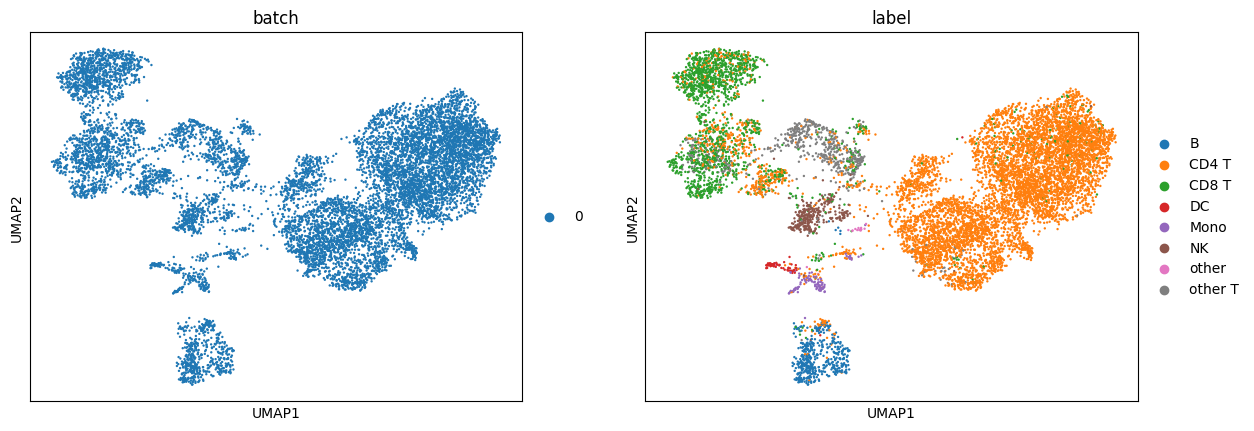

In [10]:
emb = miracle.read_embeddings()
c = emb["z"]["joint"][:, :32]
b = emb["z"]["joint"][:, 32:]
adata = sc.AnnData(c)
adata.obs_names = [i.split('_')[1] for i in pd.read_csv('./data/processed/dig_ctrl/subset_0/cell_names.csv', index_col=0).values.flatten()]
label = pd.read_csv('./data/sct/atac+rna+adt/dogma/dig_ctrl/label_seurat/l1.csv', index_col=0).astype('str').values.flatten()
adata.obs['batch'] = emb["s"]["joint"].astype('str')
adata.obs['label'] = label
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch', 'label'])

## Train the remaining batches one by one

continuously train the rest 3 batches

1 subset(s) in this path {'atac': 52867, 'adt': 208}
  subset_0 : 10190 cells ; ['atac', 'adt']
1 subset(s) in this path {'atac': 52867, 'rna': 4049}
  subset_0 :  9527 cells ; ['atac', 'rna']
load an old model from ./result/task_1/train/sp_latest.pt
Parameter number: 24.295 M
Training ...
1 tasks used as replay data, 1 tasks used as current training data


Loss: 5856.8937: 100%|██████████| 600/600 [5:07:55<00:00, 30.79s/it]  


Predicting ...
Removing directory "./result/task_2/predict/subset_0/z"
Removing directory "./result/task_2/predict/subset_1/z"
Processing subset 0: ['atac', 'adt']


100%|██████████| 40/40 [00:15<00:00,  2.56it/s]


Processing subset 1: ['atac', 'rna']


100%|██████████| 38/38 [00:16<00:00,  2.33it/s]


Packing ...
Loading predicted variables ...
Loading subset 0: z, joint


100%|██████████| 40/40 [00:00<00:00, 304.42it/s]


Loading subset 1: z, joint


100%|██████████| 38/38 [00:00<00:00, 264.58it/s]


Converting to numpy ...
Converting subset 0: s, joint
Converting subset 0: z, joint
Converting subset 1: s, joint
Converting subset 1: z, joint
Do not conduct sampling
Do not conduct sampling
Loading predicted variables ...
Loading subset 0: z, joint


100%|██████████| 40/40 [00:00<00:00, 235.26it/s]


Loading subset 1: z, joint


100%|██████████| 38/38 [00:00<00:00, 245.74it/s]


Converting to numpy ...
Converting subset 0: s, joint
Converting subset 0: z, joint
Converting subset 1: s, joint
Converting subset 1: z, joint


/tmp/ipykernel_85797/2318058927.py:25: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a.obs['label'] = all_labels[j]
/tmp/ipykernel_85797/2318058927.py:25: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a.obs['label'] = all_labels[j]
/root/anaconda3/envs/test_env3/lib/python3.11/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/root/anaconda3/envs/test_env3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/anaconda3/envs/test_env3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


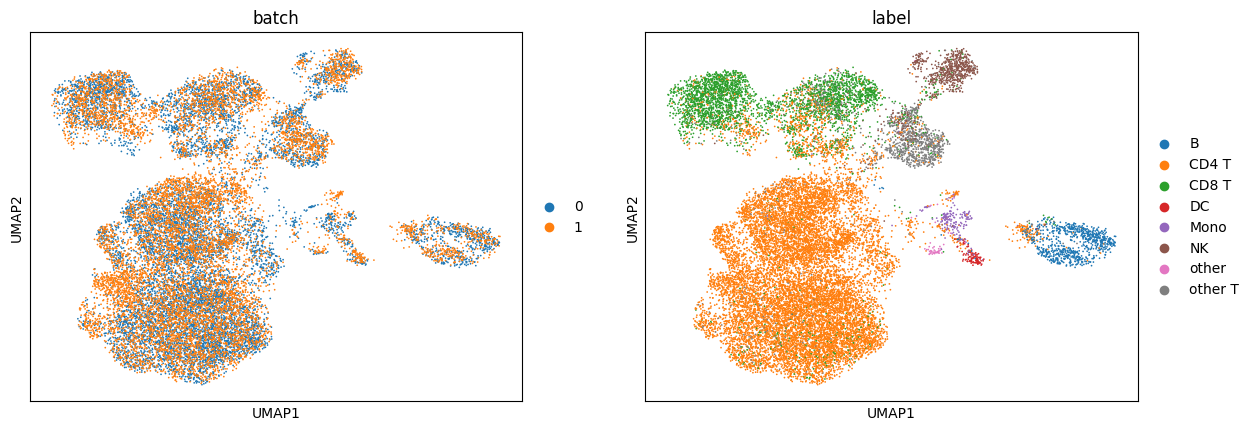

In [12]:
task = 2
data1 = create_data('/dev/shm/processed/task_%d_pack/'%(task-1))
data2 = create_data('/dev/shm/processed/%s/'%tasks[task-1])
data = [data1, data2]
status = ['replay', 'current']
miracle= MIRACLE(data, status)
miracle.init_model('continual', model_path='./result/task_%d/train/sp_latest.pt'%(task-1))
miracle.train(n_epoch=600, save_path='./result/task_%d/train/'%(task))
miracle.predict(save_dir='./result/task_%d/predict/'%(task), mod_latent=False)
miracle.pack('task_%d_pack'%(task), des_dir='/dev/shm/processed/', n_sample=20000)
emb = miracle.read_embeddings('./result/task_%d/predict/'%(task))
c = emb["z"]["joint"][:, :32]
b = emb["z"]["joint"][:, 32:]
adata = sc.AnnData(c)
adata.obs_names = np.concatenate([[j.split('_')[1] for j in d.cell_names['subset_0']] for d in data])
all_labels = [pd.read_csv(j, index_col=0) for j in list(labels.values())[:task]]
all_cell_names_orig = [[k.split('_')[1] for k in j.cell_names_orig['subset_0']] for j in data]
for j in range(len(all_labels[:task])):
    all_labels[j].index = all_cell_names_orig[j]
adata.obs['batch'] = emb["s"]["joint"].astype('str')
sub_adata = []
for j in range(task):
    a = adata[adata.obs['batch']==str(j)]
    a.obs['label'] = all_labels[j]
    sub_adata.append(a)
adata = sc.concat(sub_adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch', 'label'])

/tmp/ipykernel_85797/547580208.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a.obs['label'] = all_labels[j]
/tmp/ipykernel_85797/547580208.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a.obs['label'] = all_labels[j]
/tmp/ipykernel_85797/547580208.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a.obs['label'] = all_labels[j]
/root/anaconda3/envs/test_env3/lib/python3.11/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/root/anaconda3/envs/test_env3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/anaconda3/envs/test_env3/lib/python3.11/

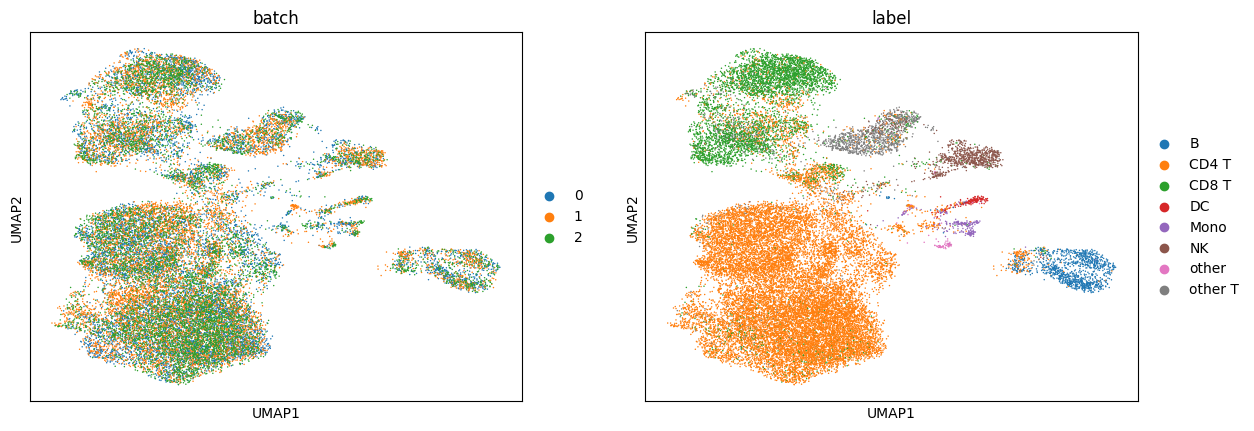

In [31]:
task = 3
data1 = create_data('/dev/shm/processed/task_%d_pack/'%(task-1))
data2 = create_data('/dev/shm/processed/%s/'%tasks[task-1])
data = [data1, data2]
status = ['replay', 'current']
miracle= MIRACLE(data, status)
miracle.init_model('continual', model_path='./result/task_%d/train/sp_latest.pt'%(task-1))
miracle.train(n_epoch=600, save_path='./result/task_%d/train/'%(task))
miracle.predict(save_dir='./result/task_%d/predict/'%(task), mod_latent=False)
miracle.pack('task_%d_pack'%(task), des_dir='/dev/shm/processed/', n_sample=20000)
emb = miracle.read_embeddings('./result/task_%d/predict/'%(task))
c = emb["z"]["joint"][:, :32]
b = emb["z"]["joint"][:, 32:]
adata = sc.AnnData(c)
adata.obs_names = np.concatenate([np.concatenate([[j.split('_')[1] for j in s] for s in d.cell_names.values()]) for d in data])
all_labels = [pd.read_csv(j, index_col=0) for j in list(labels.values())[:task]]
all_cell_names_orig = []
for d in data:
    for s in d.cell_names_orig.values():
        all_cell_names_orig.append([j.split('_')[1] for j in s])
for j in range(len(all_labels[:task])):
    all_labels[j].index = all_cell_names_orig[j]
adata.obs['batch'] = emb["s"]["joint"].astype('str')
sub_adata = []
for j in range(task):
    a = adata[adata.obs['batch']==str(j)]
    a.obs['label'] = all_labels[j]
    sub_adata.append(a)
adata = sc.concat(sub_adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch', 'label'])

3 subset(s) in this path {'atac': 52867, 'rna': 4940, 'adt': 208}
  subset_0 :  7526 cells ; ['atac', 'adt']
  subset_1 :  7036 cells ; ['atac', 'rna']
  subset_2 :  5436 cells ; ['rna', 'adt']
1 subset(s) in this path {'atac': 52867, 'rna': 4052, 'adt': 208}
  subset_0 :  5897 cells ; ['atac', 'rna', 'adt']
load an old model from ./result/task_3/train/sp_latest.pt
Parameter number: 27.051 M
Training ...
3 tasks used as replay data, 1 tasks used as current training data


Loss: 1023.6158: 100%|██████████| 600/600 [3:20:20<00:00, 20.03s/it]  


Predicting ...
Processing subset 0: ['atac', 'adt']


100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


Processing subset 1: ['atac', 'rna']


100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


Processing subset 2: ['rna', 'adt']


100%|██████████| 22/22 [00:03<00:00,  6.41it/s]


Processing subset 3: ['atac', 'rna', 'adt']


100%|██████████| 24/24 [00:13<00:00,  1.74it/s]


Packing ...
Loading predicted variables ...
Loading subset 0: z, joint


100%|██████████| 30/30 [00:00<00:00, 345.33it/s]


Loading subset 1: z, joint


100%|██████████| 28/28 [00:00<00:00, 385.92it/s]


Loading subset 2: z, joint


100%|██████████| 22/22 [00:00<00:00, 323.15it/s]


Loading subset 3: z, joint


100%|██████████| 24/24 [00:00<00:00, 351.44it/s]


Converting to numpy ...
Converting subset 0: s, joint
Converting subset 0: z, joint
Converting subset 1: s, joint
Converting subset 1: z, joint
Converting subset 2: s, joint
Converting subset 2: z, joint
Converting subset 3: s, joint
Converting subset 3: z, joint
Loading predicted variables ...
Loading subset 0: z, joint


100%|██████████| 30/30 [00:00<00:00, 393.51it/s]


Loading subset 1: z, joint


100%|██████████| 28/28 [00:00<00:00, 362.63it/s]


Loading subset 2: z, joint


100%|██████████| 22/22 [00:00<00:00, 49.57it/s]


Loading subset 3: z, joint


100%|██████████| 24/24 [00:00<00:00, 420.11it/s]


Converting to numpy ...
Converting subset 0: s, joint
Converting subset 0: z, joint
Converting subset 1: s, joint
Converting subset 1: z, joint
Converting subset 2: s, joint
Converting subset 2: z, joint
Converting subset 3: s, joint
Converting subset 3: z, joint


/tmp/ipykernel_197876/74858786.py:27: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a.obs['label'] = all_labels[j]
/tmp/ipykernel_197876/74858786.py:27: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a.obs['label'] = all_labels[j]
/tmp/ipykernel_197876/74858786.py:27: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a.obs['label'] = all_labels[j]
/tmp/ipykernel_197876/74858786.py:27: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a.obs['label'] = all_labels[j]
/root/anaconda3/envs/test_env3/lib/python3.11/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/root/anaconda3/envs/test_env3/lib/python3.11/site-packages/scanpy/plotting/_tools/sc

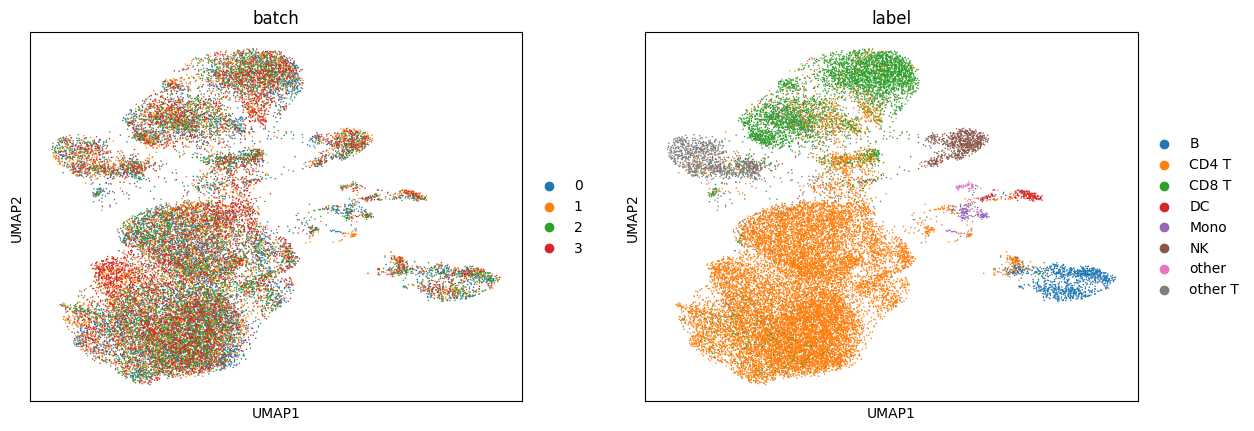

In [4]:
task = 4
data1 = create_data('/dev/shm/processed/task_%d_pack/'%(task-1))
data2 = create_data('/dev/shm/processed/%s/'%tasks[task-1])
data = [data1, data2]
status = ['replay', 'current']
miracle= MIRACLE(data, status)
miracle.init_model('continual', model_path='./result/task_%d/train/sp_latest.pt'%(task-1))
miracle.train(n_epoch=600, save_path='./result/task_%d/train/'%(task))
miracle.predict(save_dir='./result/task_%d/predict/'%(task), mod_latent=False)
miracle.pack('task_%d_pack'%(task), des_dir='/dev/shm/processed/', n_sample=20000)
emb = miracle.read_embeddings('./result/task_%d/predict/'%(task))
c = emb["z"]["joint"][:, :32]
b = emb["z"]["joint"][:, 32:]
adata = sc.AnnData(c)
adata.obs_names = np.concatenate([np.concatenate([[j.split('_')[1] for j in s] for s in d.cell_names.values()]) for d in data])
all_labels = [pd.read_csv(j, index_col=0) for j in list(labels.values())[:task]]
all_cell_names_orig = []
for d in data:
    for s in d.cell_names_orig.values():
        all_cell_names_orig.append([j.split('_')[1] for j in s])
for j in range(len(all_labels[:task])):
    all_labels[j].index = all_cell_names_orig[j]
adata.obs['batch'] = emb["s"]["joint"].astype('str')
sub_adata = []
for j in range(task):
    a = adata[adata.obs['batch']==str(j)]
    a.obs['label'] = all_labels[j]
    sub_adata.append(a)
adata = sc.concat(sub_adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch', 'label'])